# データ収集

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.12.0
Num GPUs Available:  0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# データの前処理

[ImageDataGenerator](https://keras.io/ja/preprocessing/image/#imagedatagenerator_2
)でデータを増やす

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGeneratorのインスタンスを生成

gen = ImageDataGenerator(
    featurewise_std_normalization=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    samplewise_center=True,
    zoom_range=0.6,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="constant",
    validation_split=0.1
)

# ラベル付けと正規化されたデータのバッチの生成
# バッチサイズは32
# subsetはvalidation_splitがImageDataGeneratorクラスでvalidation_splitが与えられた時に選択可能
train = gen.flow_from_directory("/content/drive/MyDrive/植物の病気データ",
    # target_size = (256,256),
    class_mode='categorical',
    subset = "training"
)
validation = gen.flow_from_directory(
    "/content/drive/MyDrive/植物の病気データ",
    # target_size = (256,256),
    class_mode='categorical',
    subset = "validation"
)

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Found 339 images belonging to 11 classes.
Found 32 images belonging to 11 classes.


(premier) : rotation_range=0.2=>45, zoom_range=0.3=>0.5
(deuxième) : rotation_range=90, zoom_range=0.6
(troisième) : ajouté horizontal & vertical


対応ラベルの確認

参考：https://github.com/keras-team/keras-preprocessing/blob/3e380065d4afc7347aaee8d89325a16b22158438/keras_preprocessing/image/directory_iterator.py#L12

119行目

In [ ]:
label_dic = train.class_indices

In [ ]:
label_dic

{'うどんこ病': 0,
 'もち病': 1,
 'ベト病': 2,
 'モザイク病': 3,
 '正常': 4,
 '炭疽病': 5,
 '白サビ病': 6,
 '角斑病': 7,
 '赤星病': 8,
 '黒星病': 9,
 '黒枯病': 10}

# モデルの導入

In [ ]:
# 必要なモジュールのインポート
# tensorflow.kerasから導入
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import experimental
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras import Model

In [ ]:
# 今回は好きなものを公式ドキュメントのApplicationsから選択
# https://keras.io/ja/applications
# include_topをFlaseにして転移学習可能にする
ResNet50 = ResNet50(weights='imagenet',include_top=False, input_tensor=Input(shape=(256,256,3
)))

94765736/94765736 [==============================] - 1s 0us/step


# 転移学習用に再構築

In [ ]:
# 追加層
inputs = ResNet50.output
x = Flatten()(inputs)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.25)(x)

prediction = Dense(11,activation='softmax')(x)

In [ ]:
# 既存層と追加層を繋げる
model=Model(inputs=ResNet50.input,outputs=prediction)

In [ ]:
# モデルの構造を確認
model.summary()

# コンパイル

kerasのoptimizersから好きなものを選択

https://keras.io/ja/optimizers/

普通のoptimizersだとエラー吐かれるので以下参考

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/SGD

In [ ]:
model.compile(optimizer=experimental.SGD(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# 学習

epochs=10=>15 X
epochs=15=>13

In [ ]:
history = model.fit(
        train,
        epochs=13,
        verbose=1,
        validation_data=validation
)

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/13


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 [==============================] - 416s 36s/step - loss: 8.6285 - accuracy: 0.1268 - val_loss: 2.9393 - val_accuracy: 0.1875
Epoch 2/13
11/11 [==============================] - 403s 37s/step - loss: 2.5671 - accuracy: 0.1652 - val_loss: 2.5691 - val_accuracy: 0.2812
Epoch 3/13
11/11 [==============================] - 407s 37s/step - loss: 2.2666 - accuracy: 0.2861 - val_loss: 3.8177 - val_accuracy: 0.0938
Epoch 4/13
11/11 [==============================] - 399s 36s/step - loss: 1.8678 - accuracy: 0.3894 - val_loss: 1.9994 - val_accuracy: 0.3750
Epoch 5/13
11/11 [==============================] - 401s 36s/step - loss: 1.6176 - accuracy: 0.4779 - val_loss: 2.1100 - val_accuracy: 0.4375
Epoch 6/13
11/11 [==============================] - 392s 35s/step - loss: 1.3866 - accuracy: 0.5369 - val_loss: 2.0248 - val_accuracy: 0.4375
Epoch 7/13
11/11 [==============================] - 392s 37s/step - loss: 1.2681 - accuracy: 0.5900 - val_loss: 2.3398 - val_accuracy: 0.5000
Epoch 8/13
11/11 

# 分析

In [ ]:
import matplotlib.pyplot as plt

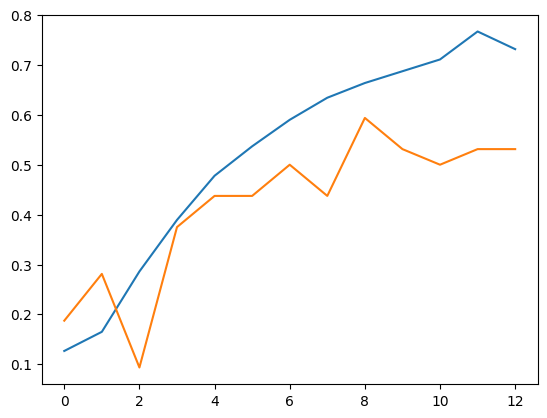

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# テスト

In [ ]:
import os
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

In [ ]:
# パスの名前からテニスかゴルフかバスケか判断する関数の作成
def get_label(path):
  if "うどんこ病" in path:
    return "うどんこ病"
  elif "もち病" in path:
    return "もち病"
  elif "ベト病" in path:
    return "ベト病"
  elif "モザイク病" in path:
    return "モザイク病"
  elif "正常" in path:
    return "正常"
  elif "炭疽病" in path:
    return "炭疽病"
  elif "白サビ病" in path:
    return "白サビ病"
  elif "角斑病" in path:
    return "角斑病"
  elif "赤星病" in path:
    return "赤星病"
  elif "黒星病" in path:
    return "黒星病"
  elif "黒枯病" in path:
    return "黒枯病"
  else:
    pass

In [ ]:
# テストデータで精度を確認
root_path = "/content/drive/MyDrive/検証"
test_img_list = os.listdir(root_path)
true_num = 0
false_num = 0
for path in test_img_list:
  input = image.load_img(os.path.join(root_path,path),target_size=(256,256))
  input = np.expand_dims(input,axis=0)
  input = preprocess_input(input)
  result = model.predict(input)
  predict_label = list(label_dic.keys())[np.argmax(result[0])]
  acc_label = get_label(path)
  print(predict_label, acc_label)
  # 正答率計算
  if predict_label == acc_label:
    true_num += 1

print("正答率は{}".format(true_num/(len(test_img_list))))

1/1 [==============================] - 3s 3s/step
正常 None
1/1 [==============================] - 1s 710ms/step
モザイク病 None
1/1 [==============================] - 1s 854ms/step
ベト病 None
1/1 [==============================] - 1s 662ms/step
白サビ病 None
1/1 [==============================] - 0s 370ms/step
白サビ病 None
1/1 [==============================] - 0s 331ms/step
角斑病 None
1/1 [==============================] - 0s 330ms/step
正常 もち病
1/1 [==============================] - 0s 333ms/step
正常 もち病
1/1 [==============================] - 0s 326ms/step
白サビ病 角斑病
1/1 [==============================] - 0s 322ms/step
黒星病 角斑病
1/1 [==============================] - 0s 355ms/step
角斑病 黒枯病
1/1 [==============================] - 0s 372ms/step
角斑病 黒枯病
1/1 [==============================] - 1s 517ms/step
角斑病 黒星病
1/1 [==============================] - 1s 532ms/step
黒枯病 黒星病
1/1 [==============================] - 1s 528ms/step
黒枯病 炭疽病
1/1 [==============================] - 0s 484ms/step
炭疽病 炭疽病
1/1 [=========

In [ ]:
print(path)

leaf-spot-fungus.webp


# モデル保存

In [ ]:
model

[Savedmodel](https://www.tensorflow.org/guide/keras/save_and_serialize?hl=ja#savedmodel_%E5%BD%A2%E5%BC%8F)形式で保存


In [ ]:
# モデルが良ければ保存
model.save("./ball")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("./ball")

In [ ]:
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7efc762988e0>>

In [ ]:
# テストデータで精度を確認
root_path = "./test_data"
test_img_list = os.listdir(root_path)
true_num = 0
false_num = 0
for path in test_img_list:
  input = image.load_img(os.path.join(root_path,path),target_size=(256,256))
  input = np.expand_dims(input,axis=0)
  input = preprocess_input(input)
  result = model.predict(input)
  predict_label = list(label_dic.keys())[np.argmax(result[0])]
  acc_label = get_label(path)
  print(predict_label, acc_label)
  # 正答率計算
  if predict_label == acc_label:
    true_num += 1

print("正答率は{}".format(true_num/(len(test_img_list))))

1/1 [==============================] - 2s 2s/step
golfball golfball
1/1 [==============================] - 0s 43ms/step
tennisball golfball
1/1 [==============================] - 0s 33ms/step
golfball golfball
1/1 [==============================] - 0s 30ms/step
golfball golfball
1/1 [==============================] - 0s 31ms/step
tennisball golfball
1/1 [==============================] - 0s 30ms/step
basketball basketball
1/1 [==============================] - 0s 32ms/step
basketball basketball
1/1 [==============================] - 0s 30ms/step
basketball basketball
1/1 [==============================] - 0s 31ms/step
basketball basketball
1/1 [==============================] - 0s 29ms/step
basketball basketball
1/1 [==============================] - 0s 29ms/step
tennisball tennisball
1/1 [==============================] - 0s 30ms/step
tennisball tennisball
1/1 [==============================] - 0s 39ms/step
tennisball tennisball
1/1 [==============================] - 0s 32ms/step
tenn

In [ ]:
model.save("./ball.h5")

In [ ]:
modelh5 = load_model("./ball.h5")

In [ ]:
# テストデータで精度を確認
root_path = "test_data"
test_img_list = os.listdir(root_path)
true_num = 0
false_num = 0
for path in test_img_list:
  input = image.load_img(os.path.join(root_path,path),target_size=(256,256))
  input = np.expand_dims(input,axis=0)
  input = preprocess_input(input)
  result = modelh5.predict(input)
  predict_label = list(label_dic.keys())[np.argmax(result[0])]
  acc_label = get_label(path)
  print(predict_label, acc_label)
  # 正答率計算
  if predict_label == acc_label:
    true_num += 1

print("正答率は{}".format(true_num/(len(test_img_list))))

1/1 [==============================] - 2s 2s/step
golfball golfball
1/1 [==============================] - 0s 43ms/step
tennisball golfball
1/1 [==============================] - 0s 28ms/step
golfball golfball
1/1 [==============================] - 0s 27ms/step
golfball golfball
1/1 [==============================] - 0s 27ms/step
tennisball golfball
1/1 [==============================] - 0s 28ms/step
basketball basketball
1/1 [==============================] - 0s 32ms/step
basketball basketball
1/1 [==============================] - 0s 27ms/step
basketball basketball
1/1 [==============================] - 0s 28ms/step
basketball basketball
1/1 [==============================] - 0s 28ms/step
basketball basketball
1/1 [==============================] - 0s 27ms/step
tennisball tennisball
1/1 [==============================] - 0s 26ms/step
tennisball tennisball
1/1 [==============================] - 0s 31ms/step
tennisball tennisball
1/1 [==============================] - 0s 28ms/step
tenn